In [1]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate
%pip install pyxirr
%pip install openpyxl
%pip install folium

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#local models
from typing import Dict
from models.econometrics import Cost, Currency
from models.components import Component
from models.econometrics import Cost
from models.geometry import Orientation
from models.photovoltaic import Photovoltaic


#init project
from models.components import Tech
from models.consumption import Energetic
from models.inventory import Building, Project
import pandas as pd

In [3]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

## Address and general info🌎

## Energy Consumptions🔌

In [4]:
#cspell:disable

project:Project = Project(
    title='Sistema Fotovoltaico OnGrid-Mixto',
    building = Building(
        geolocation=(-33.735228, -71.424153),
        name='Posta Rural Cuncumen',
        address='Ruta G-814 SN Cuncumen',
        city='San Antonio'),
    technology= [Tech.PHOTOVOLTAIC],
    consumption= {
        'description':'main',
        'energetic':Energetic.ELI,
        'cost_increment':8/100,
        'consumption':[
            (625,"04-08-2023",98195),
            (464,"05-09-2023",72901),
            (449,"05-10-2023",70545),
            (417,"07-11-2023",65515),
            (400,"08-12-2023",62845),
            (432,"09-01-2024",67871),
            (368,"10-02-2024",57819),
            (427,"09-05-2024",67085),
            (462,"10-04-2024",72587),
            (645,"11-05-2024",111291),
            (611,"11-06-2024",126715),
            ],
        }
    )

getting weather data...
api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-33.735228&longitude=-71.424153&start=20230101&end=20231231&format=JSON
getting currencies data...
set $1 Peso Chileno... on USD$0.00 
set $1 UF............. on USD$39.27 
set $1 UTM............ on USD$68.60 
set $1 Euro........... on USD$1.05 
set $1 Pound.......... on USD$1.26 
set $1 Real........... on USD$0.17 
adding consumptions data...


# Integration 

## Machine Components 🎡

In [5]:
#cspell: disable

#clean previous load
project.components = {}
from IPython.display import clear_output

from libs.repository import repo
from models.energy_storage import Battery
from models.photovoltaic import Length, PvTechnicalSheet
clear_output(wait=True)

# assembly projects components
project.add_component(
    'generación',
    Photovoltaic(project.weather,'Módulo Primario FV A',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel PV 650W 48V',
                quantity=10,
                cost=Cost(208437,Currency.CLP),
                orientation=Orientation(15,98),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    generator=True
    )

project.add_component(
    'auxiliar',
    repo['inverter']['Solis 6kW'],
    Component('Controlador de Carga',
                model='Enertik 80A 12/24V',
                specification='1000W to 2000 24V output',
                cost_per_unit=Cost(101600,Currency.CLP)),
    Component('medidor bidireccional',
                model='Elster AS1440',
                specification='Trifasico',
                cost_per_unit=Cost(306990,Currency.CLP)),
    Battery('almacenamiento',
                model='MP GEL12-250',
                reference='https://www.tiendatecnored.cl/bateria-gel-ciclo-profundo-12v-250ah.html',
                cost_per_unit=Cost(305990,Currency.CLP),
                volt=12,
                charge=250,
                demand=project.building.consumption_forecast(['main'])['energy'].to_list(),
                hours_autonomy=6,
                use_regime='8/7',
                )
    )

#gen number of panels
pv_quantity = sum(list(map(lambda it:it.quantity,project.components['generación'])))

project.add_component(
    'obras',
    Component(description='instalación eléctrica',
            specification='H/P eléctrico',
            cost_per_unit=Cost(1,currency=Currency.UF),
            quantity=pv_quantity*5,
            ),
    Component(description='estructura de soporte',
            specification='elementos fijación',
            cost_per_unit=Cost((4*800+11400/4+4*700+4000+500)),
            quantity=pv_quantity*5,
            )
)


inside cost pv :  208437 Currency.CLP
boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625


# Write Document 📒


In [6]:
import os
PATH = 'build/'+f'r_{project.building.city.lower()[:3]}_{project.building.name}/'

if not os.path.exists(PATH):
    #create
    os.makedirs(PATH)

### Saving results on EXCEL ❎

In [7]:
from models.plotter import toTable
toTable(project,PATH)

boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625


### Generate Context->Doc📄✍️

In [8]:
from docxtpl import DocxTemplate # type: ignore
#init doc
#assembly proxy object 
memory_report = DocxTemplate("templates/memory_template.docx")
bidding_report = DocxTemplate("templates/bidding_template.docx")

## Write params and tables

In [9]:
#loading context
#cspell: disable
memory_report.render(project.context(template=memory_report))
bidding_report.render(project.context(template=bidding_report))


boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625
boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625
boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625
boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625


## Insert Plots 📊

boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625
boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot_done


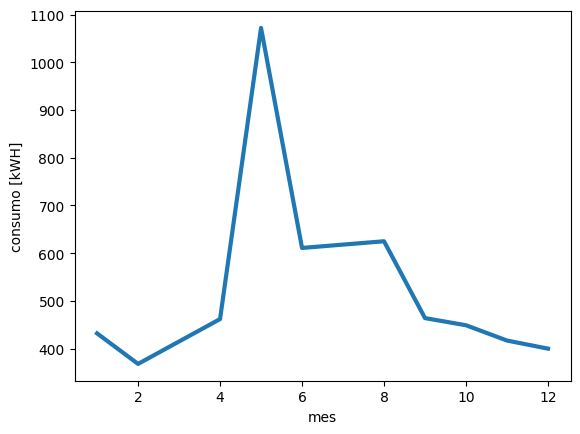

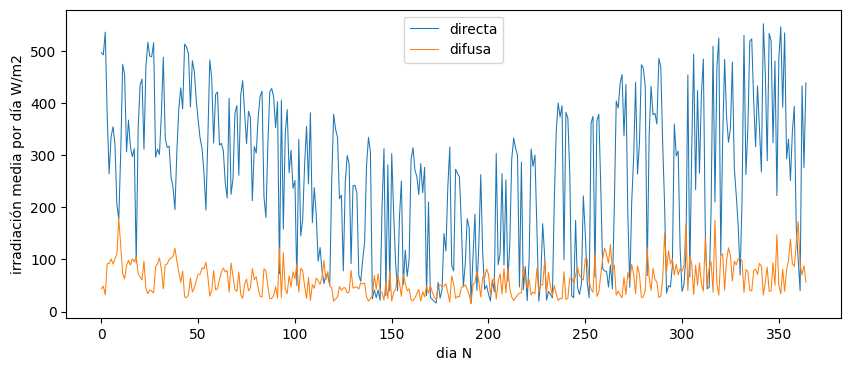

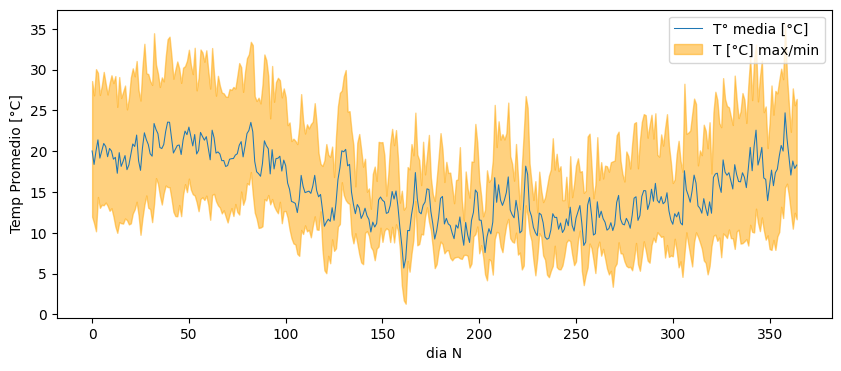

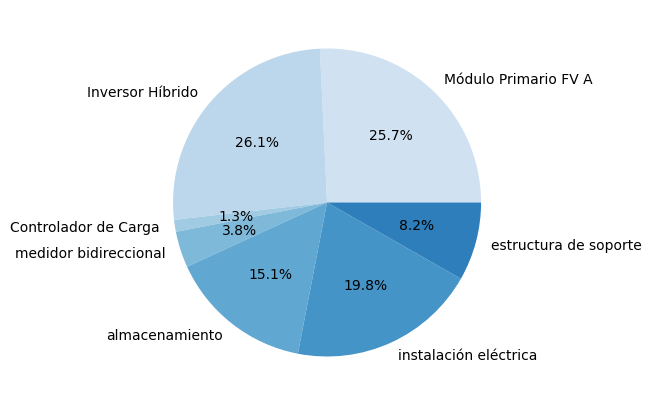

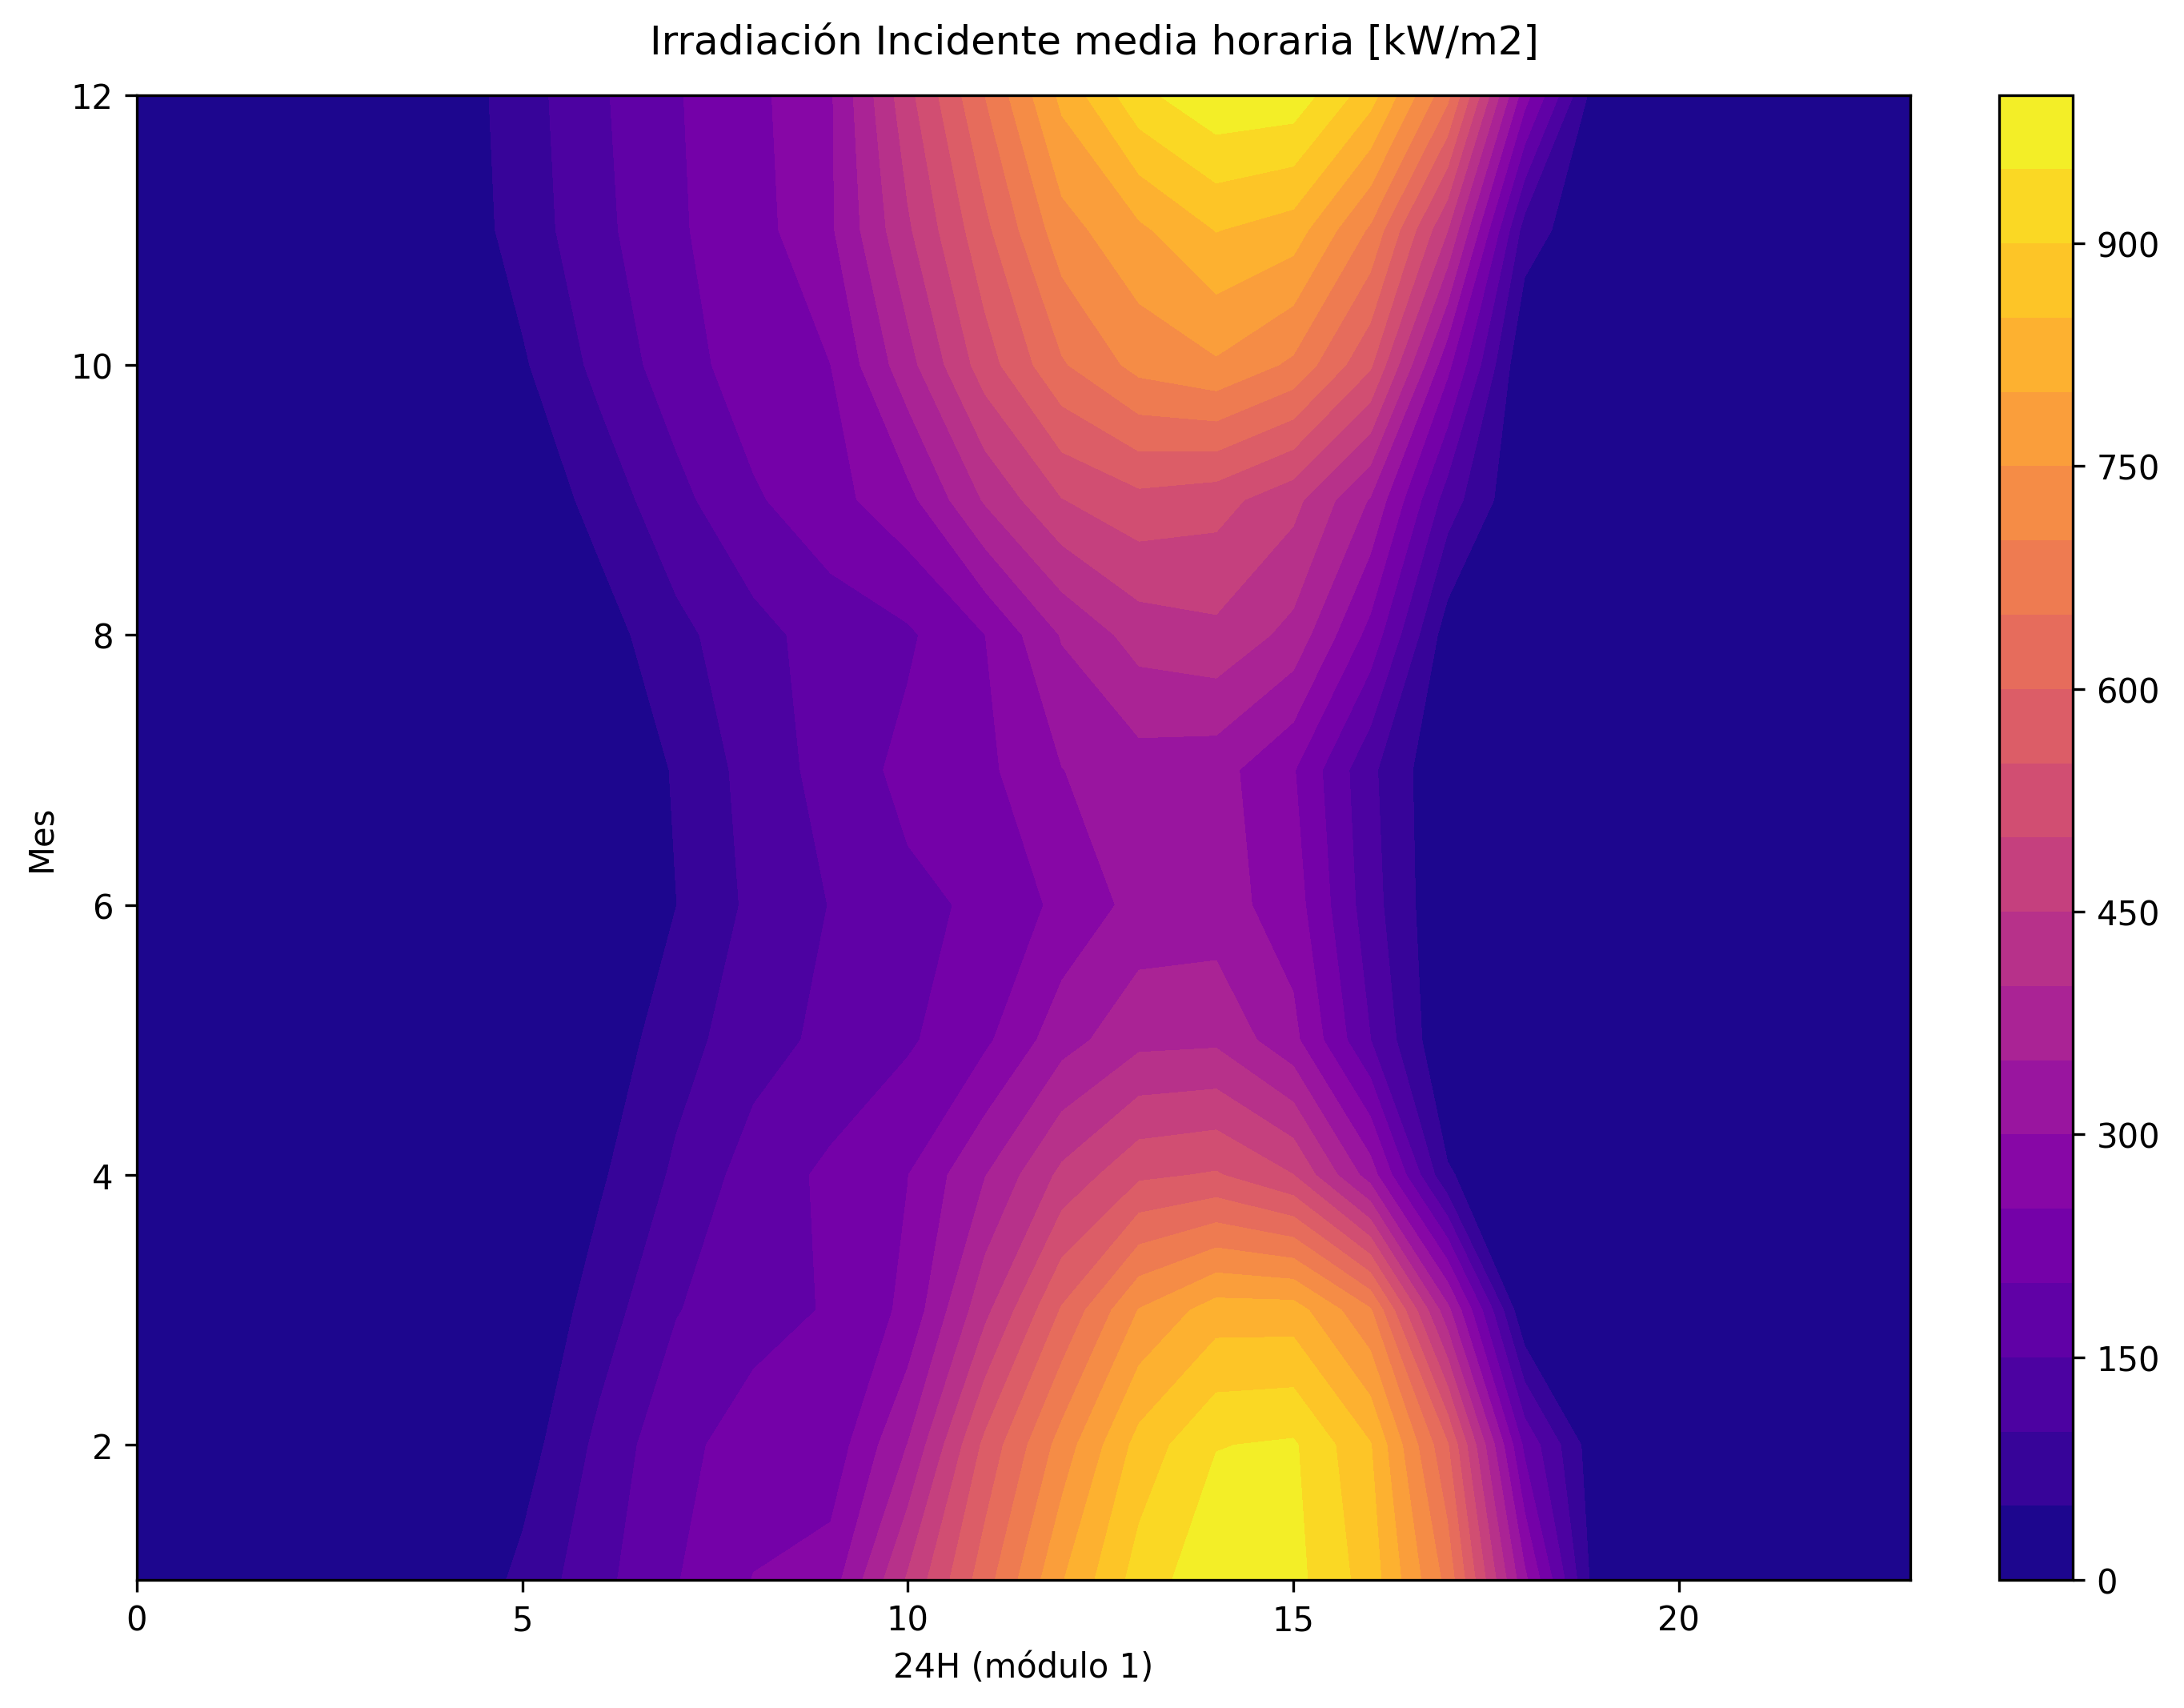

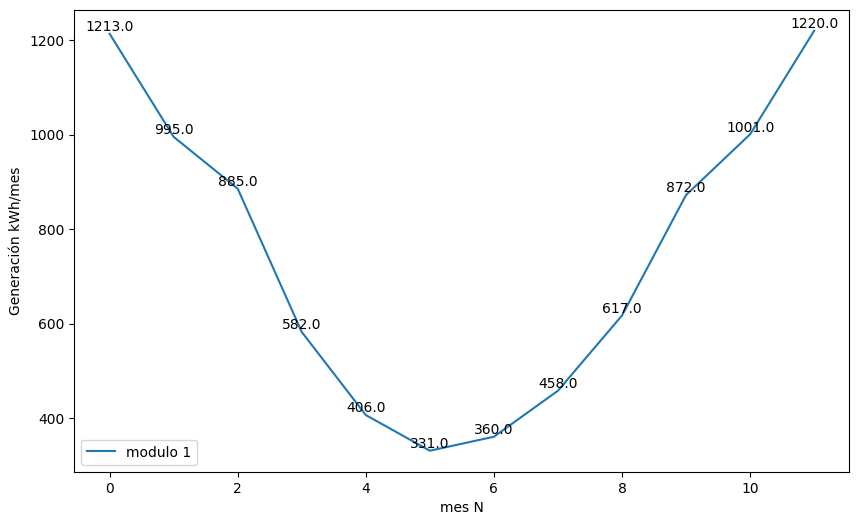

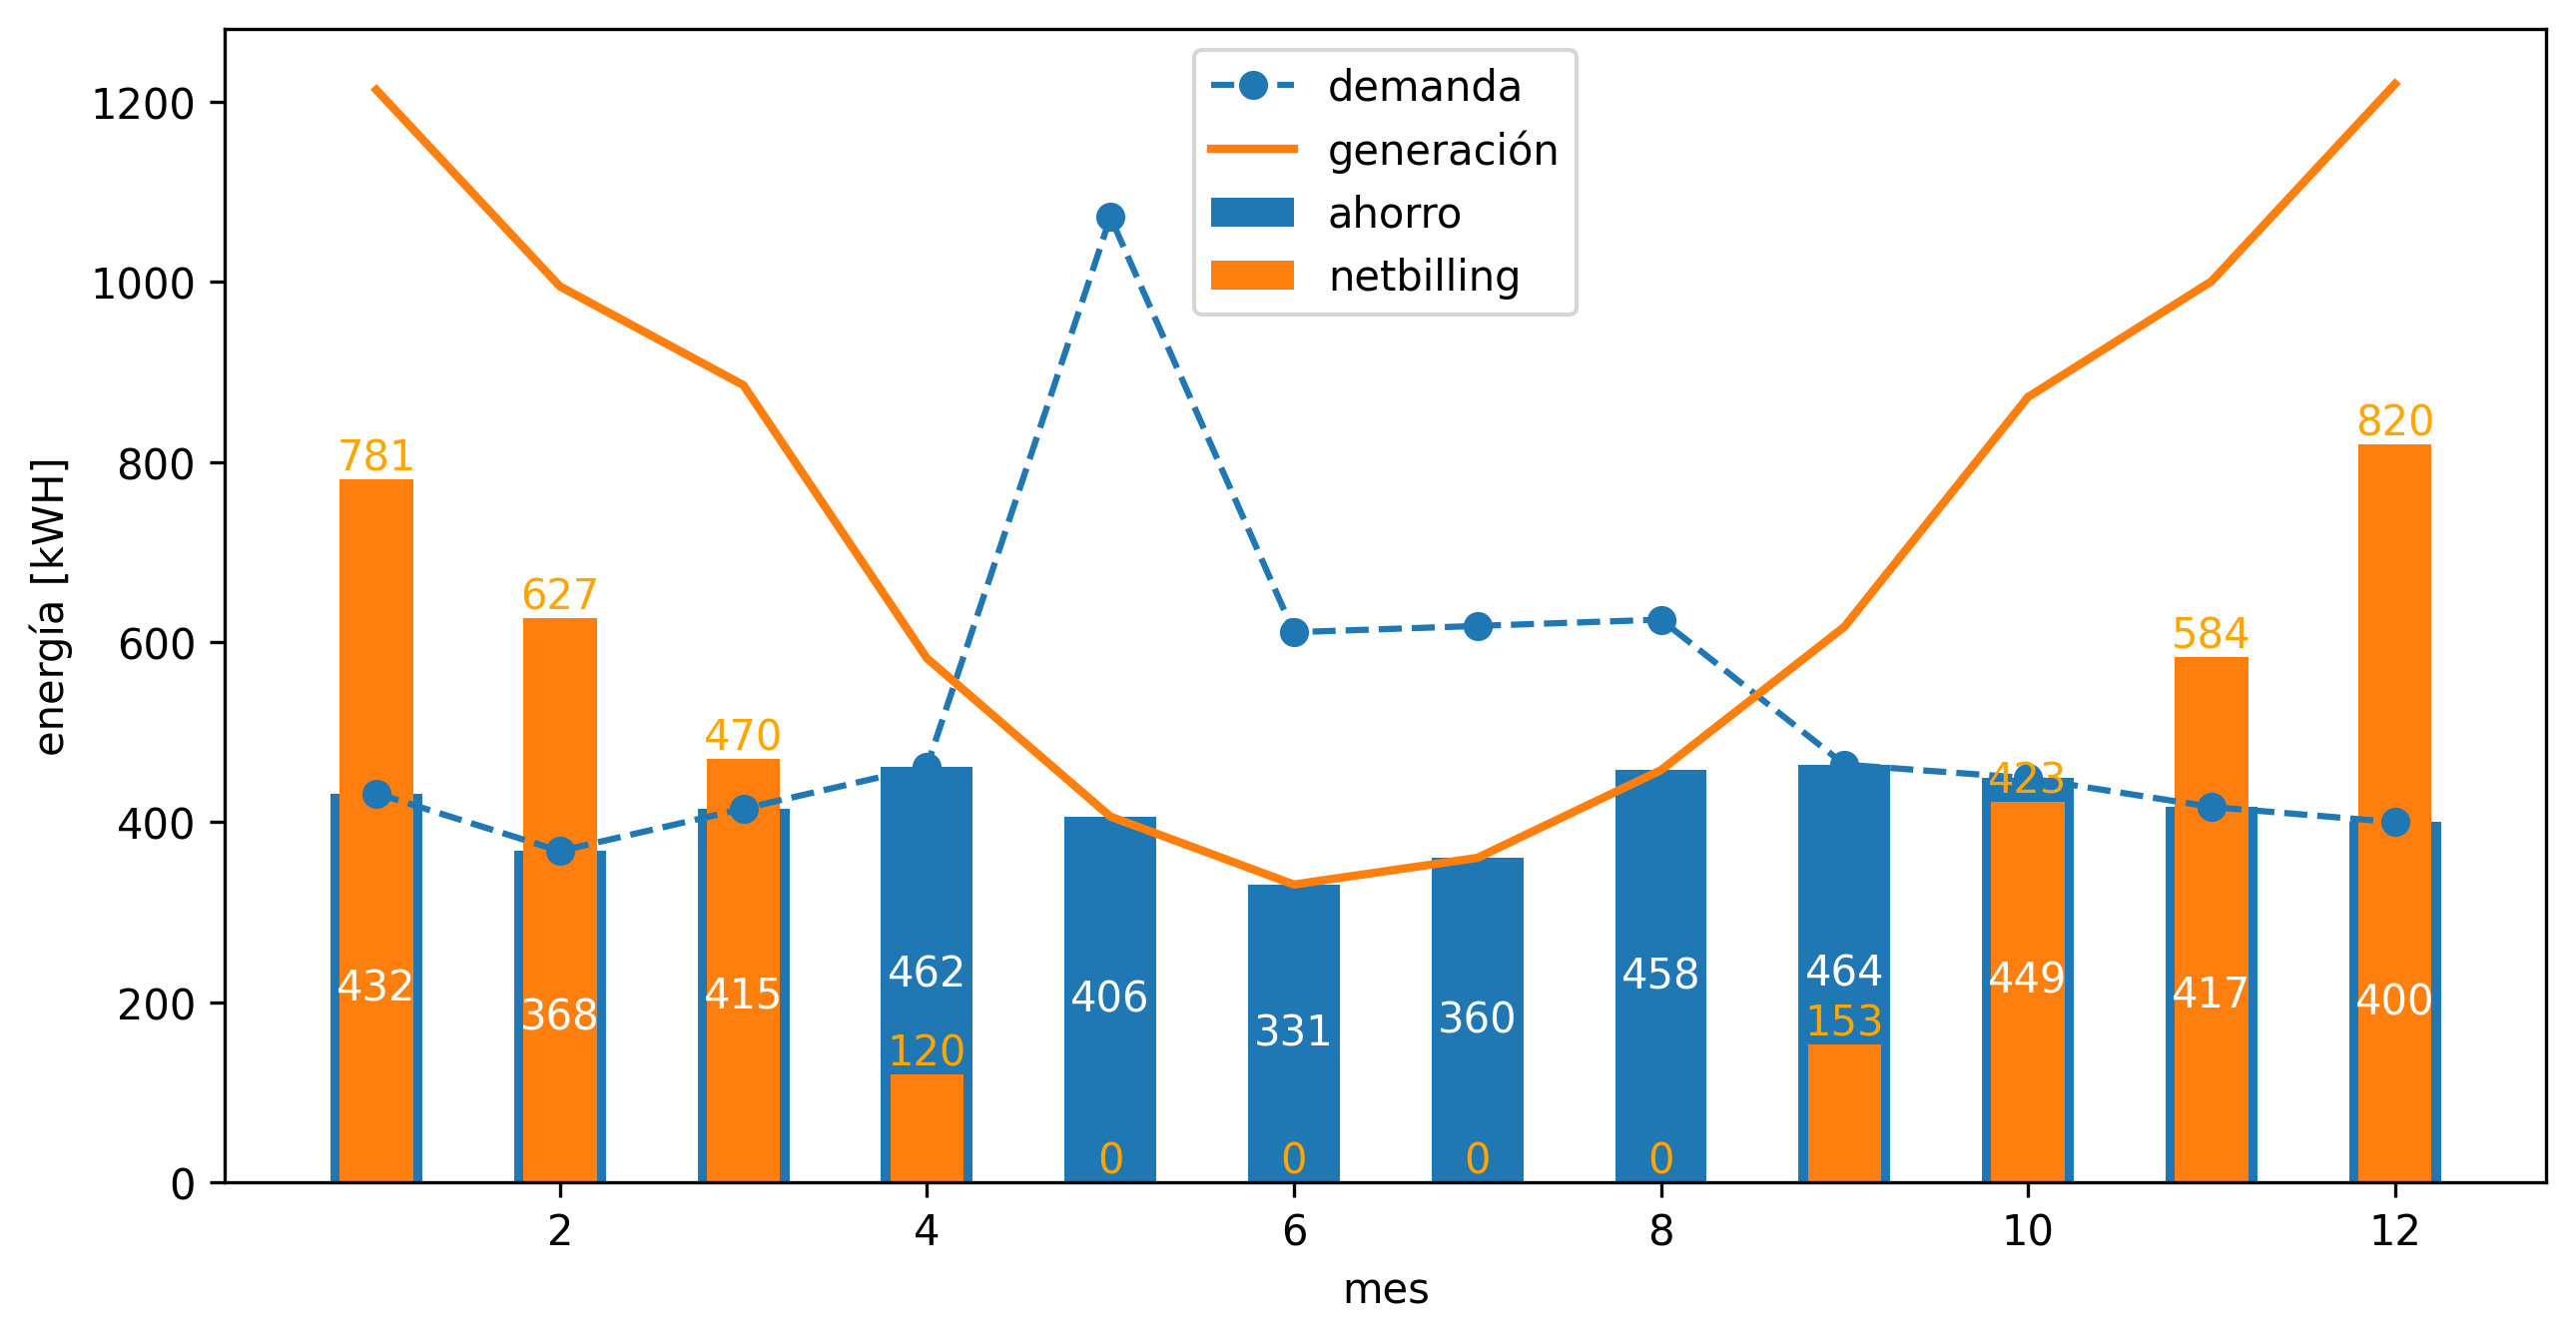

<Figure size 1920x1440 with 0 Axes>

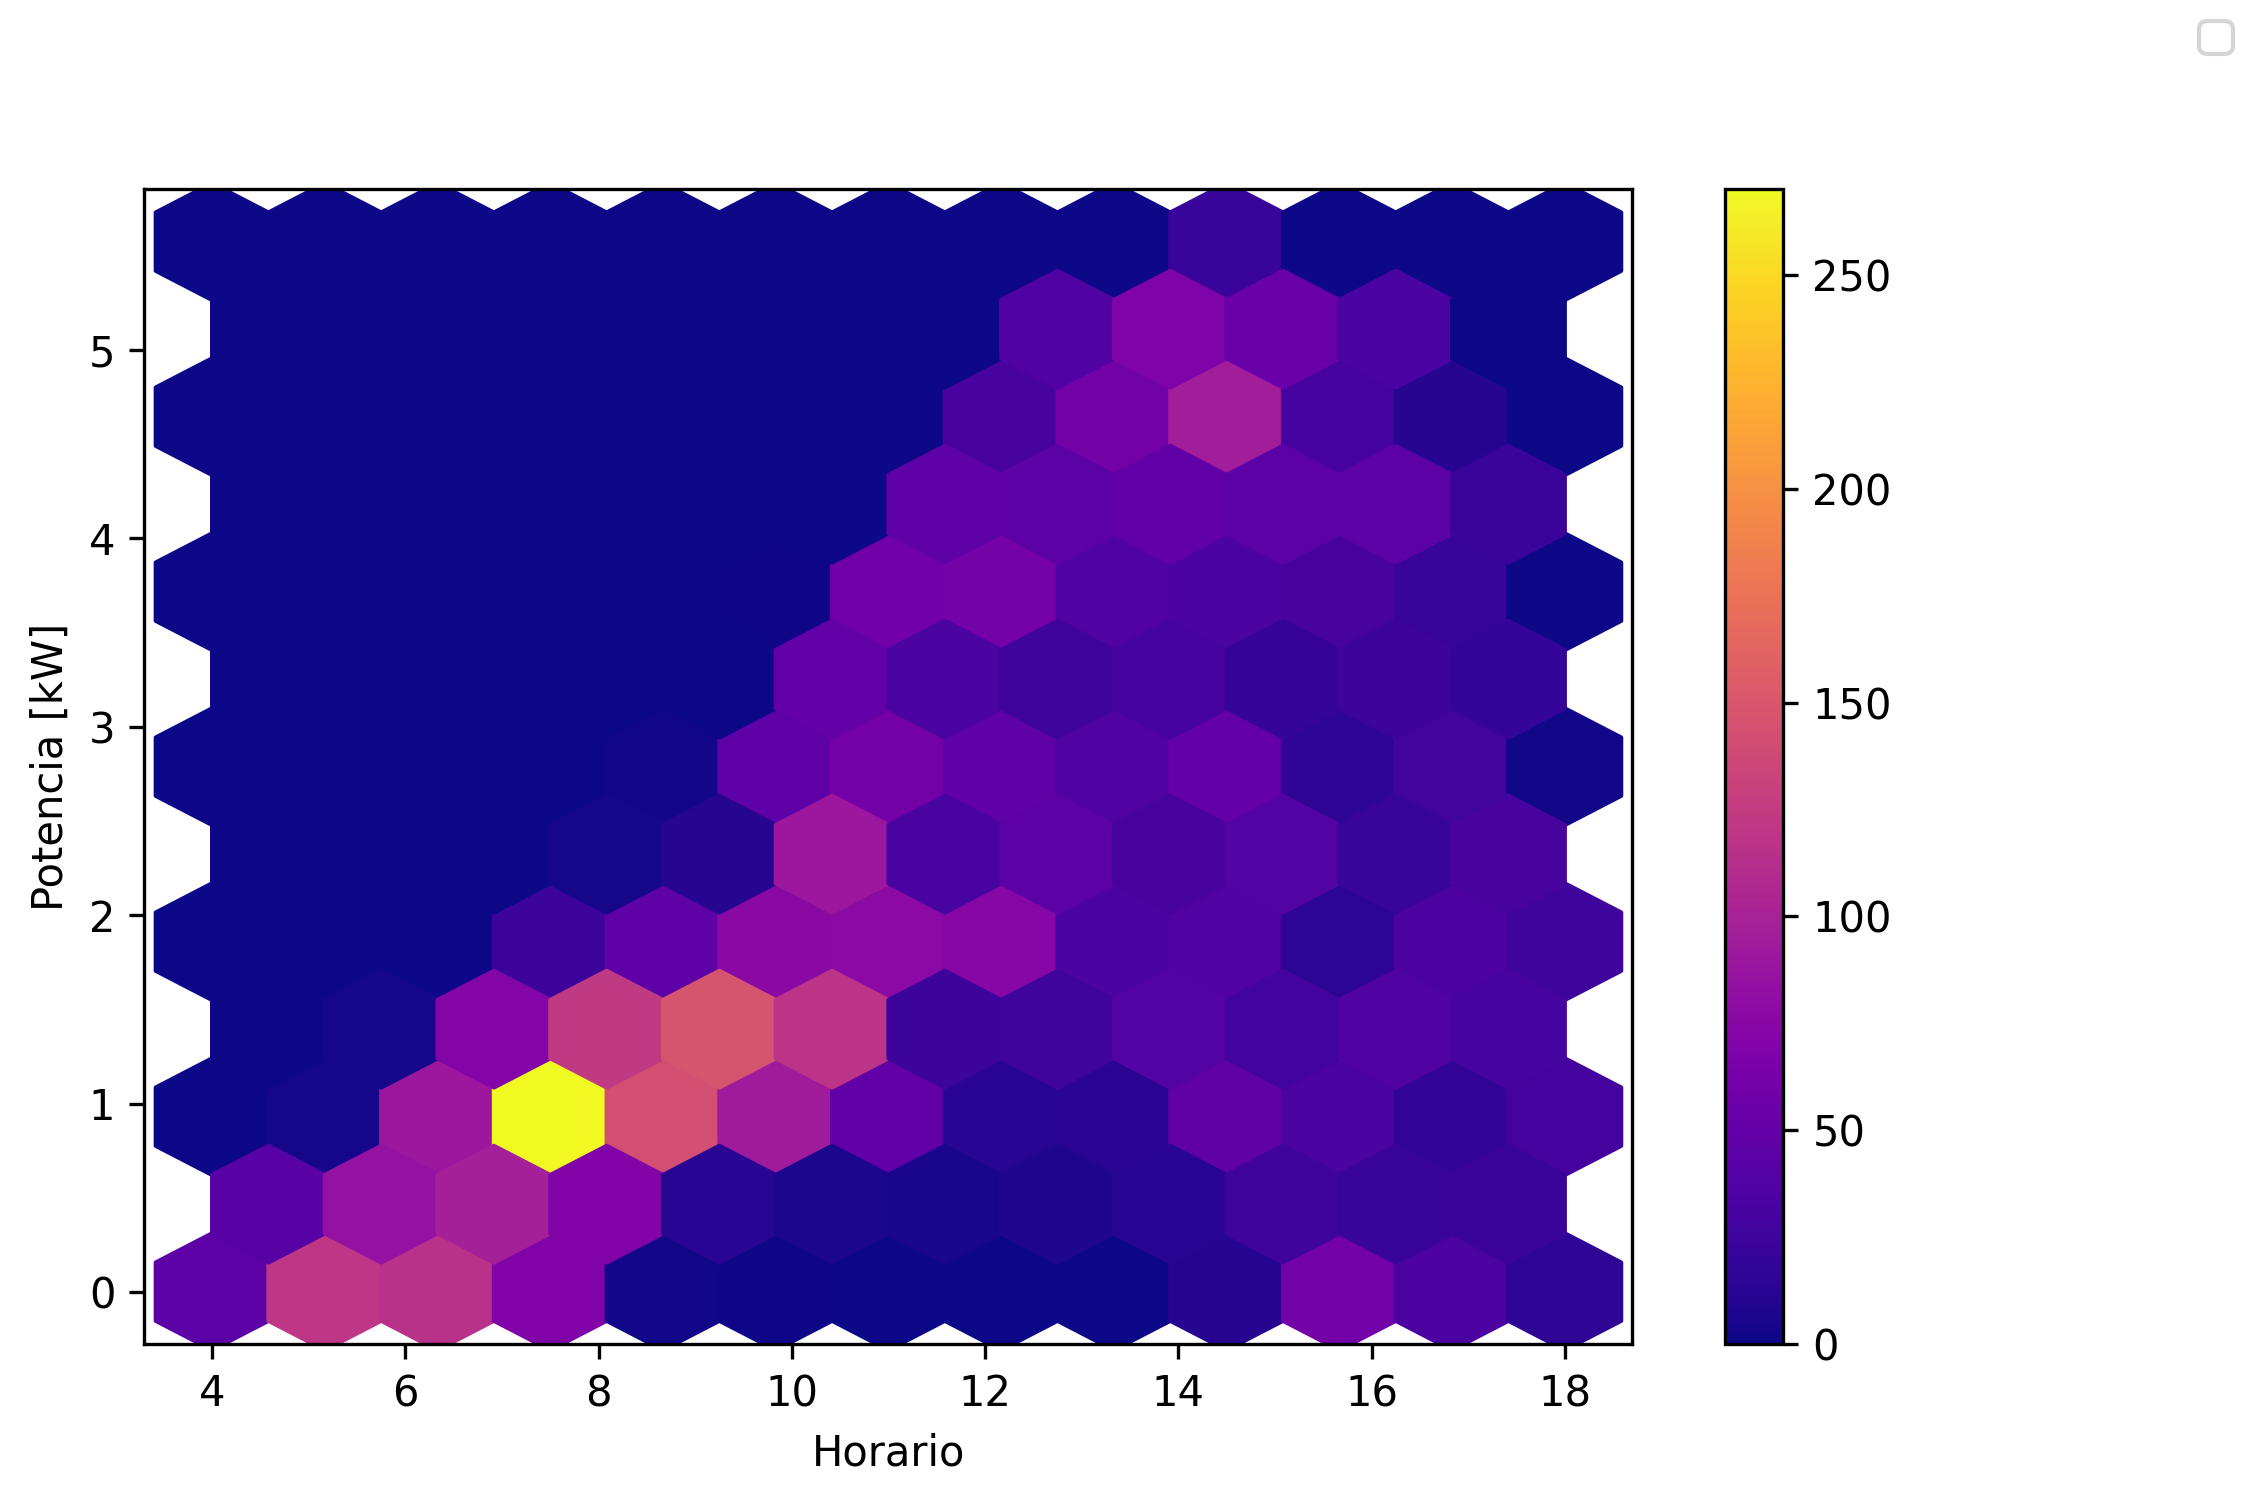

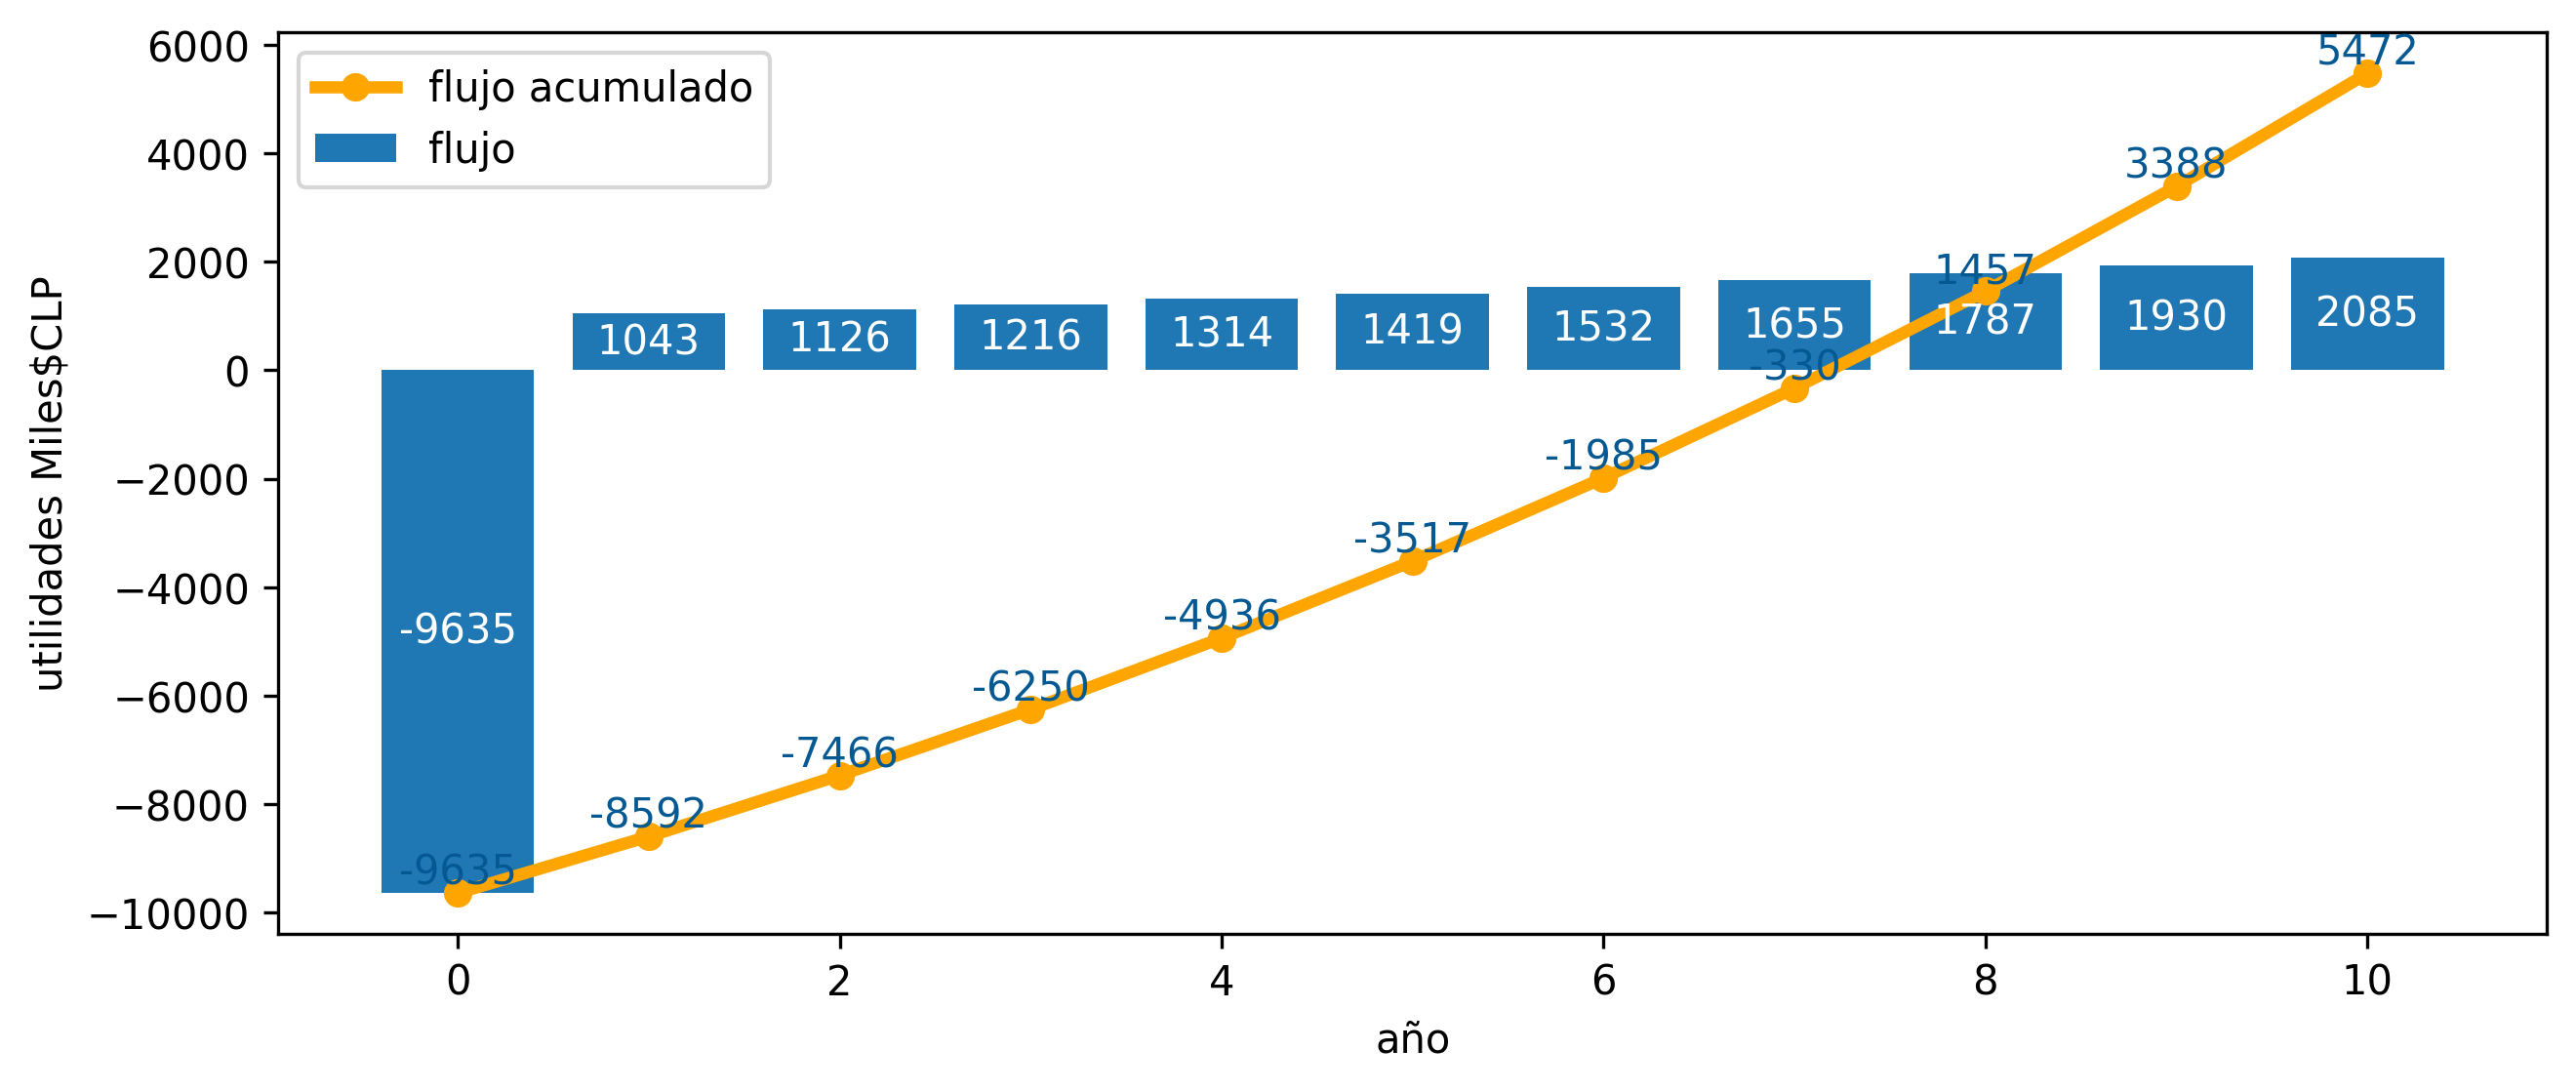

In [10]:
#dep
from models.plotter import plotter
plotter(project,PATH)

In [11]:
#set into doc
plot_list = [
    'plot_consumption_forecast',
    'plot_irradiance',
    'plot_temperature',
    'plot_components',
    'plot_components_irr',
    'plot_components_production',
    'plot_production_performance',
    'plot_performance_frequency',
    'plot_flux',
]

for plot in plot_list:
    memory_report.replace_pic(plot,PATH+f'{plot}.png')
    print('replaced plot:',plot)

replaced plot: plot_consumption_forecast
replaced plot: plot_irradiance
replaced plot: plot_temperature
replaced plot: plot_components
replaced plot: plot_components_irr
replaced plot: plot_components_production
replaced plot: plot_production_performance
replaced plot: plot_performance_frequency
replaced plot: plot_flux


In [12]:
memory_report.save(PATH+f"reporte_memoria_calculo.docx")
bidding_report.save(PATH+f"reporte_pliegos_técnicos.docx")

# Result

In [ ]:
res = project.context(template=None)

boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625
boundaries in month 3 : 368 <-> 462
boundaries in month 7 : 611 <-> 625


{'report_date': 'Fri, 22 de November 2024',
 'report_version': 'ver.6a9aad56',
 'project': <models.inventory.Project at 0x1f2f6663620>,
 'gmaps': <docxtpl.richtext.RichText at 0x1f2f7ca22a0>,
 'project_type': 'Fotovoltaico',
 'project_size': '6.55 kW',
 'total_cost': 'CLP$ 9,635,218',
 'annual_benefits': 'CLP$ 1,042,874',
 'energy_production': '8941 kWh/año',
 'energy_netbilling': '3978 kWh/año',
 'energy_savings': '4962 kWh/año',
 'emission_reduction': '1,821.80 kg CO2',
 'emission_forecast': '0.2378 Ton CO2/MWh',
 'table_emission_historic': '|   year |   emission |\n|-------:|-----------:|\n|   2018 |     0.4187 |\n|   2019 |     0.4056 |\n|   2020 |     0.3834 |\n|   2021 |     0.3907 |\n|   2022 |     0.3006 |\n|   2023 |     0.2421 |',
 'table_emission_reduction': '|   mes |   CO2 kg |\n|------:|---------:|\n|     1 |   247.23 |\n|     2 |   202.76 |\n|     3 |   180.41 |\n|     4 |   118.6  |\n|     5 |    82.78 |\n|     6 |    67.4  |\n|     7 |    73.44 |\n|     8 |    93.29 |\

In [14]:
from datetime import datetime
print('work',project,'finish at: ',datetime.now())

work <models.inventory.Project object at 0x000001F2F6663620> finish at:  2024-11-22 12:35:35.179193
